In [1]:
import numpy as np

import seaborn as sn

import torch
from torchvision.datasets import EMNIST

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

from emnist import list_datasets
from emnist import extract_training_samples
from emnist import extract_test_samples

In [2]:
print(list_datasets())

x_train, y_train = extract_training_samples('letters')

print("train shape:", x_train.shape)
print("train labels:", y_train.shape)

x_test, y_test = extract_test_samples('letters')

print("test shape:", x_test.shape)
print("test labels:", y_test.shape)

np.array(np.unique(y_train, return_counts=True)).T
np.array(np.unique(y_test, return_counts=True)).T

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']
train shape: (124800, 28, 28)
train labels: (124800,)
test shape: (20800, 28, 28)
test labels: (20800,)


array([[  1, 800],
       [  2, 800],
       [  3, 800],
       [  4, 800],
       [  5, 800],
       [  6, 800],
       [  7, 800],
       [  8, 800],
       [  9, 800],
       [ 10, 800],
       [ 11, 800],
       [ 12, 800],
       [ 13, 800],
       [ 14, 800],
       [ 15, 800],
       [ 16, 800],
       [ 17, 800],
       [ 18, 800],
       [ 19, 800],
       [ 20, 800],
       [ 21, 800],
       [ 22, 800],
       [ 23, 800],
       [ 24, 800],
       [ 25, 800],
       [ 26, 800]], dtype=int64)

(4, 6)
letter: w (id: 23)
letter: g (id: 7)
letter: p (id: 16)
letter: o (id: 15)
letter: w (id: 23)
letter: q (id: 17)
letter: m (id: 13)
letter: k (id: 11)
letter: v (id: 22)
letter: x (id: 24)
letter: j (id: 10)
letter: n (id: 14)
letter: r (id: 18)
letter: u (id: 21)
letter: z (id: 26)
letter: u (id: 21)
letter: u (id: 21)
letter: x (id: 24)
letter: s (id: 19)
letter: e (id: 5)
letter: b (id: 2)
letter: y (id: 25)
letter: i (id: 9)
letter: e (id: 5)


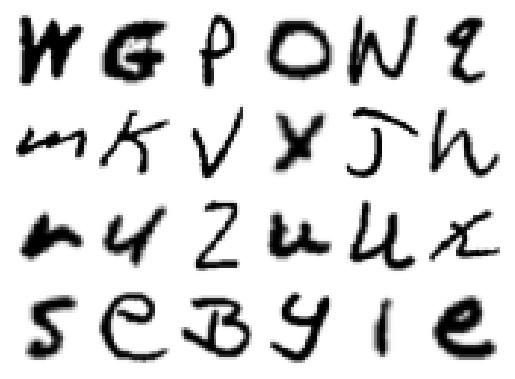

In [3]:
def plot():
  fig = plt.figure()
  w, h = (6, 4)
  gs = fig.add_gridspec(h, w, hspace=0, wspace=0)
  sp = gs.subplots(sharex='col', sharey='row')
  print(sp.shape)
  for y in range(0, h):
    for x in range(0, w):
      i = y*w+x
      letter = chr(y_train[i] - 1 + ord('a'))
      sp[y][x].matshow(x_train[i], cmap='binary')
      sp[y][x].axis('off')
      print(f"letter: {letter} (id: {y_train[i]})")
plot()

In [4]:
def prepare(x, y):
  x = x.reshape(-1, 28, 28, 1).astype("float32") / 255
  y = np_utils.to_categorical(y, 27)
  return (x, y)

(x_train, y_cat_train) = prepare(x_train, y_train)
(x_test, y_cat_test) = prepare(x_test, y_test)

print(x_train.shape)
print(y_cat_train.shape)
print(x_test.shape)
print(y_cat_test.shape)

(124800, 28, 28, 1)
(124800, 27)
(20800, 28, 28, 1)
(20800, 27)


In [5]:
hyper_params = [
  ("3x3_max_50", 3, 0.50, layers.MaxPooling2D),
  ("5x5_max_50", 5, 0.50, layers.MaxPooling2D),
  ("3x3_avg_50", 3, 0.50, layers.AveragePooling2D),
  ("5x5_avg_50", 5, 0.50, layers.AveragePooling2D),
  ("3x3_max_25", 3, 0.25, layers.MaxPooling2D),
  ("3x3_max_75", 3, 0.75, layers.MaxPooling2D)
]

results = []

for (name, conv, dropout, pooling) in hyper_params:
  print(f"Testing {name}.")
  cnn = models.Sequential([
      layers.Convolution2D(filters=16,
                          kernel_size=(conv,conv),
                          padding = 'same',
                          strides=1,
                          activation ='relu',
                          input_shape=(28, 28, 1)),
      pooling(pool_size=(2,2), strides=(2,2), padding = 'same'),

      layers.Convolution2D(filters=32,
                          kernel_size=(conv,conv),
                          padding = 'same',
                          strides=1,
                          activation ='relu'),
      pooling(pool_size=(2,2), strides=(2,2), padding = 'same'),

      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(dropout),
      layers.Dense(27, activation = 'softmax')
  ])

  cnn.summary()

  cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{name}", histogram_freq=1)

  history = cnn.fit(x_train,
                    y_cat_train,
                    batch_size=64,
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_cat_test),
                    callbacks=[tb_callback])

  print(history.history.keys())

  results.append((
    name,
    history.history['accuracy'],
    history.history['val_accuracy'],
    history.history['loss'],
    history.history['val_loss'],
    tf.math.confusion_matrix(labels=y_test, predictions=[np.argmax(i) for i in cnn.predict(x_test)])
  ))

Testing 3x3_max_50.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 

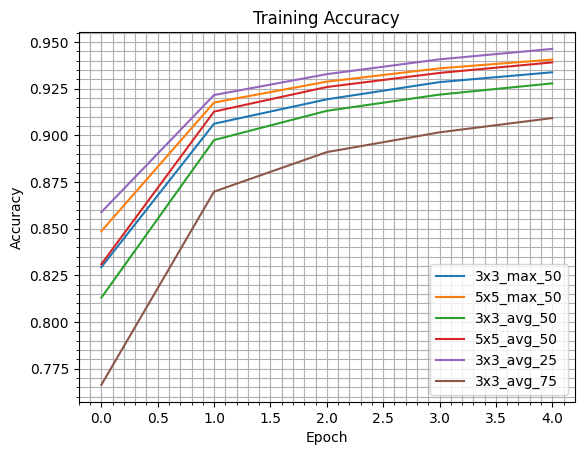

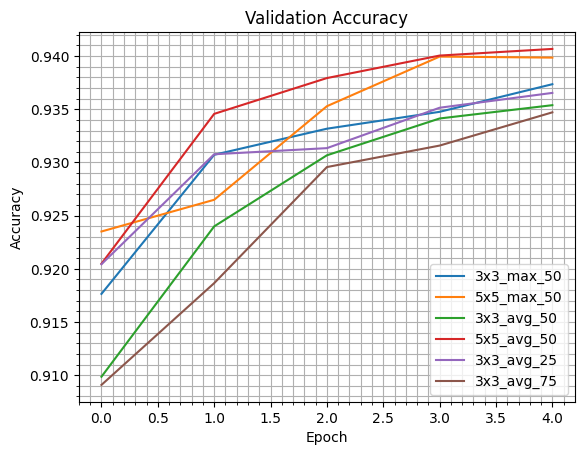

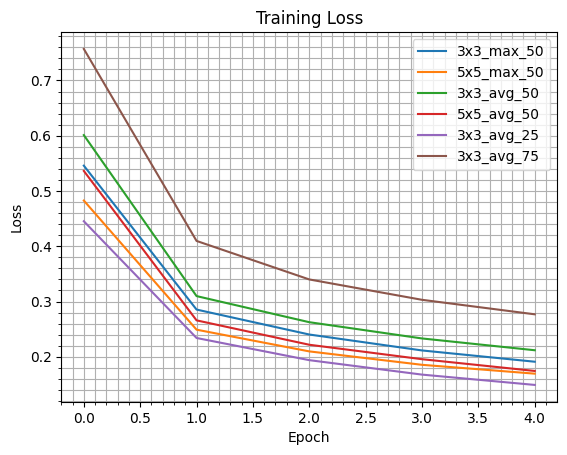

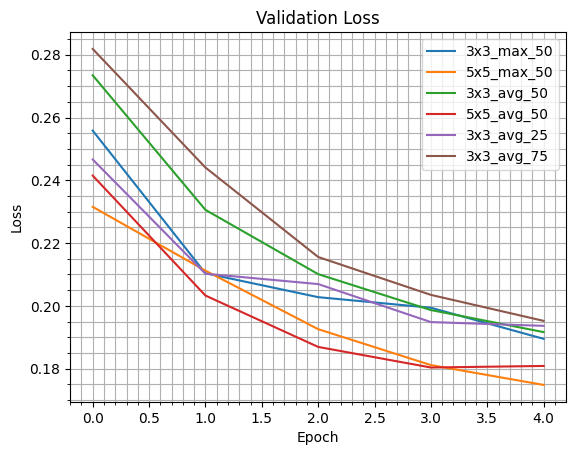

In [78]:
def micro_plot(title, id, y, loc):
  plt.title(title)
  plt.minorticks_on()
  ax = plt.gca()
  ax.grid(which='both')
  ax.set_ylabel(y)
  ax.set_xlabel('Epoch')
  for r in results:
    r = r[id]
    ax.plot(r)
  ax.legend([r[0] for r in results], loc=loc)
  plt.show()

micro_plot("Training Accuracy", 1, "Accuracy", 'lower right')
micro_plot("Validation Accuracy", 2, "Accuracy", 'lower right')
micro_plot("Training Loss", 3, "Loss", 'upper right')
micro_plot("Validation Loss", 4, "Loss", 'upper right')

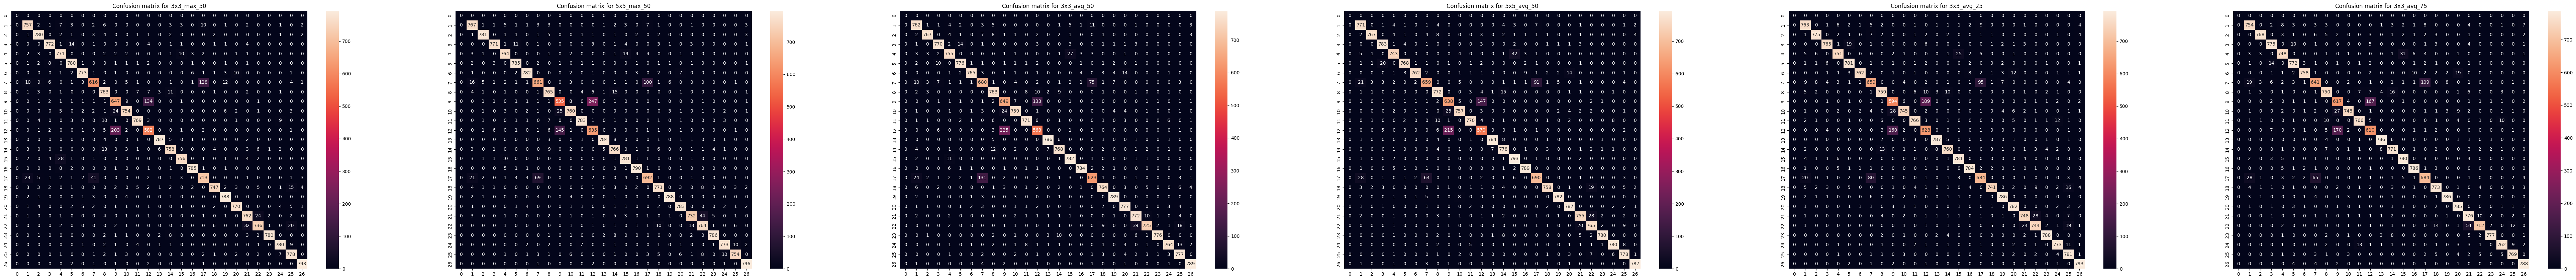

In [79]:
fig, axs = plt.subplots(1, len(results))
fig.set_figheight(10)
fig.set_figwidth(100)
plt.ylabel('Truth')
plt.xlabel('Predicted')
for i, (name, train_acc, val_acc, train_loss, val_loss, confusion_matrix) in enumerate(results):
  ax = axs[i]
  ax.set_title(f'Confusion matrix for {name}')
  sn.heatmap(confusion_matrix, annot=True, fmt='d', ax=ax)
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=C:/prg/lapki/ml_s6/logs